## 3.0 Импорты библиотек

In [1]:
import os
import yaml
import logging
import numpy as np
import importlib
import subprocess
import scipy.stats as stats
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Any, Optional, Tuple, Dict
from datetime import datetime
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr, kurtosis, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from ydata_profiling import ProfileReport

D:\Skills\Kaggle\ml-regression_concrete-strength\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# расширяем поле ноутбука для удобства
from IPython.display import display, HTML
display(HTML('<style>.container {width:87% !important;}</style>'))
display(HTML("<style>.output_scroll {height:auto !important; max-height:10000px !important;}</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# Настройки для pandas (количество отображаемых колонок)
pd.set_option('display.max_columns', 100)

In [5]:
# Определение стиля для pyplot
plt.style.use('ggplot')

In [6]:
# Текущая рабочая директория
cwd = Path().resolve()

# Поднимаемся на один уровень выше
project_root = cwd.parent

# Добавляем корень проекта в sys.path
sys.path.append(str(project_root))

# Загрузка данных из config.yaml
from src.data import downloader, loader, preprocessor, saving
from src.features import engineer
from src.models import modeling
from src.analysis import eda
from src.visualization import visualization

# Путь к файлу config.yaml
config_path = project_root / "config" / "config.yaml"

# Загружаем конфиг
config = loader.load_config(config_path)

## 3.1. Загрузка данных

### Скачивание данных с kaggle и распаковка архива .zip

In [7]:
downloader.download_and_extract_competition(config)

[⧗] Загружаю данные соревнования skillbox-ml-junior-regression-10 в D:\Skills\Kaggle\ml-regression_concrete-strength\data\raw...
[i] Файлы уже существуют. Используйте force_redownload=True для перезагрузки.


### Загрузка train и test

In [8]:
# Загрузка train
df_train = loader.data_load(data_type='train', config=config)

[⧗] Загружаю данные из: ..\data/raw\train.csv
[✓] Данные успешно загружены. Форма: (800, 10)


In [9]:
# Загрузка test
df_test = loader.data_load(data_type='test', config=config)

[⧗] Загружаю данные из: ..\data/raw\test.csv
[✓] Данные успешно загружены. Форма: (230, 9)


In [10]:
# Вывод первых 5 строк тренировочного датасета
df_train.head()

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,230,376.0,0.0,0.0,214.6,0.0,1003.5,762.4,3,16.28
1,231,491.0,26.0,123.0,210.0,3.9,882.0,699.0,56,59.59
2,232,250.0,0.0,95.7,187.4,5.5,956.9,861.2,3,13.82
3,233,310.0,0.0,0.0,192.0,0.0,1012.0,830.0,90,35.76
4,234,252.1,97.1,75.6,193.8,8.3,835.5,821.4,28,33.40


In [11]:
# Вывод первых 5 строк тестового датасета
df_test.head()

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,0,167.4,129.9,128.6,175.5,7.8,1006.3,746.6,28
1,1,475.0,118.8,0.0,181.1,8.9,852.1,781.5,7
2,2,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,100
3,3,307.0,0.0,0.0,193.0,0.0,968.0,812.0,365
4,4,143.6,0.0,174.9,158.4,17.9,942.7,844.5,28


## 3.2. Предварительная очистка и создание инженерных признаков

In [12]:
# Удаление неинформативных столбцов и дубликатов
df_train_cleaned = preprocessor.preliminary_data_cleaning(df_train)
df_test_cleaned = preprocessor.preliminary_data_cleaning(df_test)

In [13]:
# Создание признаков (w_c, SP_pct)
df_train_feat = preprocessor.add_concrete_ratios(df_train_cleaned)
df_test_feat = preprocessor.add_concrete_ratios(df_test_cleaned)

df_train_feat.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength,W/C,Sp/C_pct
0,376.0,0.0,0.0,214.6,0.0,1003.5,762.4,3,16.28,0.570745,0.000000
1,491.0,26.0,123.0,210.0,3.9,882.0,699.0,56,59.59,0.427699,0.007943
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,3,13.82,0.749600,0.022000
3,310.0,0.0,0.0,192.0,0.0,1012.0,830.0,90,35.76,0.619355,0.000000
4,252.1,97.1,75.6,193.8,8.3,835.5,821.4,28,33.40,0.768743,0.032923


## 3.3. Оценка объема данных и выбор алгоритмов

In [14]:
# Формируем список алгоритмов исходя из объема данных по правилу NEPV
models = modeling.check_models_by_nepv(df_train_feat, config)

[REGRESSION] Правило NEPV: 781 наблюдений / 11 признаков = 71.00
LinearRegression / Ridge / Lasso — соответствуют (≥ 20)
CHAID (не реализован в sklearn) — соответствует (≥ 50)
Сложные модели (RF, Boosting и др.) — не соответствуют (< 200)
DecisionTreeRegressor (CART) — добавлен с осторожностью. NEPV к нему не применяется строго.

Список рекомендованных моделей: ['LinearRegression', 'Ridge', 'Lasso', 'DecisionTreeRegressor']


## 3.4. Проверка порядка признаков в тренировочном и тестовом датасете

In [15]:
# Сравниваем порядок признаков в тренировочном и тестовом датасете
flag_oreder_features = preprocessor.checking_order_of_features(df_train_feat,
                                                               df_test_feat)

Порядок признаков совпадает


## 3.5. Генерация EDA отчета

#### Предварительный отчет

In [ ]:
# Общая информация
df_train_feat.info()

In [ ]:
# Проверка на пропуски train
df_train_feat.isna().sum()

In [ ]:
# Проверка на пропуски test
df_train_feat.isna().sum()

In [ ]:
# Основные статистики train
df_train_feat.describe()

#### Генерация подробного отчета ydataprofaling

In [ ]:
# Генерация отчета по тренировочным данным с помощью ydata-profiling
eda.eda_report(df_train_feat, "train", config, base_path="..")

## 3.6. Анализ выбросов

#### Анализ выбросов

In [16]:
# Построение сводной таблицы по выбросам на оснвове IQR и значений ГОСТ
summary_df,  outlier_masks_df = eda.detect_outliers(df_train_feat, config)
summary_df

,feature,Q1,Q3,IQR,Lower_Bound,Upper_Bound,n_outliers_IQR,standard_min,standard_max,n_outliers_standard
0,Age,14.000,56.000,42.000,-49.000,119.000,49,1.000,365.000,0.0
1,W/C,0.542,0.935,0.393,-0.048,1.525,13,0.300,0.700,387.0
2,Water,166.600,193.000,26.400,127.000,232.600,12,120.000,220.000,51.0
3,Superplasticizer,0.000,10.000,10.000,-15.000,25.000,9,NaN,NaN,NaN
4,Sp/C_pct,0.000,0.039,0.039,-0.059,0.098,8,0.005,0.025,685.0
5,Fine Aggregate,721.000,821.400,100.400,570.400,972.000,3,600.000,800.000,310.0
6,Strength,23.740,46.230,22.490,-9.995,79.965,3,5.000,100.000,3.0
7,Blast Furnace Slag,0.000,139.900,139.900,-209.850,349.750,1,NaN,NaN,NaN
8,Cement,194.700,350.000,155.300,-38.250,582.950,0,200.000,600.000,202.0
9,Fly Ash,0.000,118.300,118.300,-177.450,295.750,0,0.000,200.000,1.0


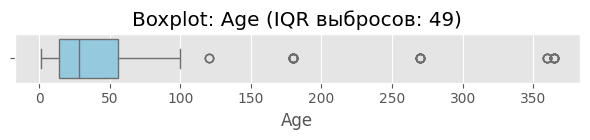

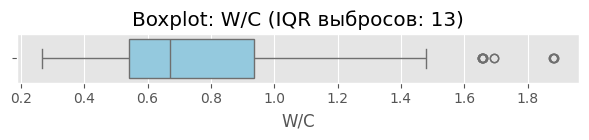

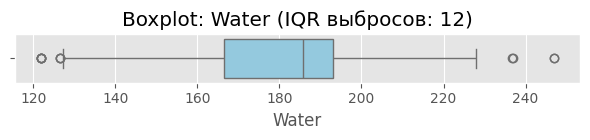

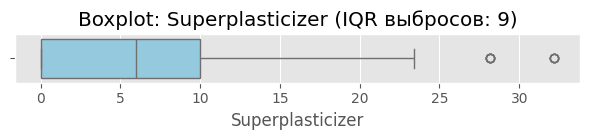

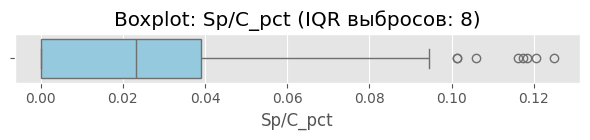

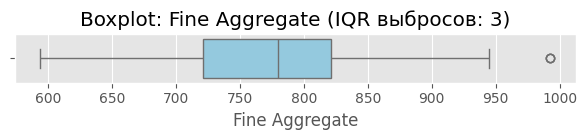

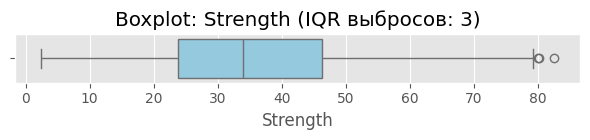

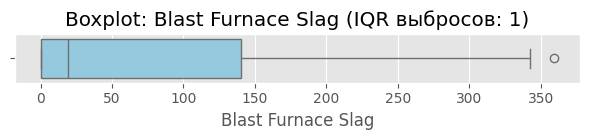

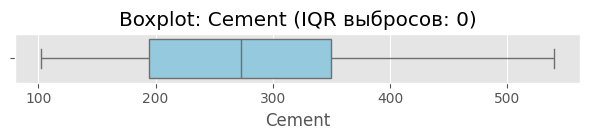

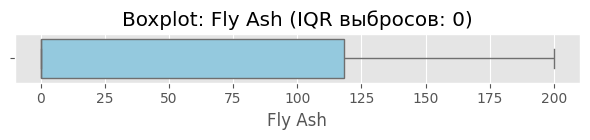

In [17]:
# Построение графиков 
visualization.plot_outliers(df_train_feat, summary_df, max_plots=10)

In [ ]:
# Сохранение отчетов
output_dir=Path().resolve().parent / config["output"]["eda_report_dir"]

saving.save_outliers_report(summary_df, output_dir=output_dir)

## 3.7. Анализ нулей в признаках

#### Анализ признаков с нулнвыми значениями

In [17]:
config = eda.analyze_zeros(df_train_feat, config)

Анализ значимости нулевых значений для признаков:
✓ Blast Furnace Slag: p-value = 1.21e-09 - Добавляем бинарный признак
  Welch's t-test (дисперсии не равны), p-value Левене = 0.003
----------------------------------------
✗ Fly Ash: p-value = 0.280 - Признак не добавляем
  Welch's t-test (дисперсии не равны), p-value Левене = 0.000
----------------------------------------
✓ Superplasticizer: p-value = 6.06e-14 - Добавляем бинарный признак
  Student's t-test (дисперсии равны), p-value Левене = 0.220
----------------------------------------


## 3.8. Анализ зависимости целевой переменнной от признаков

### Анализ корреляции целевой переменнной и признаков

In [ ]:
# Создает комплексный датафрейм c результатами анализа
# корреляции признаков и целевой переменной
df_corr_target = engineer.create_feature_analysis(df_train_feat)
df_corr_target

**Выводы:** Признак Fly Ash показывает очень слабую и статистически незначимую связь с целевой переменной Strength. Поэтому его стоит объединить с другими признаками или удалить

In [ ]:
# Визуализация анализа признаков
visualization.visualize_feature_analysis(df_corr_target) 

In [ ]:
# 
df_trend_results = engineer.plot_feature_trends_orchestrator(df_train_feat,
                                                             config, 
                                                             target='Strength',
                                                             figsize=(16, 50),
                                                             alpha=0.25)

In [ ]:
# Выводим датасет преобразований признаков и значений R2
df_trend_results

### Анализ мультиколлинеарности признаков

In [ ]:
# Вывод матрицы корреляций
vif_results = engineer.check_multicollinearity(df_train_feat,                                               
                                               threshold=5)

In [ ]:
# Отображаем значения VIF для признаков
styled_vif = engineer.highlight_high_vif(vif_results)
display(styled_vif)

**Выводы:** высокая корреляция между признаками Superplasticizer и Sp/C_pct; а также W/C и Cement. Основной вариант действий: удаление признаков Cement и Superplasticizer

## 3.9. Сохранение данных

In [18]:
# Сохраняем train в различных форматах, а пути к файлам в config
saving.save_cleaned_data(df_train_feat, "train", config)

In [19]:
# Сохраняем train в различных форматах, а пути к файлам в config
saving.save_cleaned_data(df_test_feat, "test", config)

In [ ]:
# Обновляем congig.yaml
with open(config_path, "w", encoding="utf-8") as f:
    yaml.dump(config, f)